In [3]:
import random
import os
import csv

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.python.client import device_lib

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import layers
from keras.layers.regularization.dropout import Dropout
from keras.layers import BatchNormalization
from keras import models
from keras.optimizers import SGD

import seaborn as sns

import pandas as pd

Checking if GPU is enabled since the notebook is locally hosted

In [95]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6761823061926267661
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6242172928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15570297650105535275
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Data loading and visualisation

The Data is loaded and we can see that the shape is not of the correct format for CNN so we shift the axis by -1 so that the shape is correct. We can also see by printing some of the data that it is already divided by 255 as the values are between 0 and 1.

In [5]:
trn = np.load('trnImage.npy')
trnlb_coarse = np.load('trnLabel_coarse.npy')
trnlb_fine = np.load('trnLabel_fine.npy')

tst = np.load('tstImage.npy')
tstlb_coarse = np.load('tstLabel_coarse.npy')
tstlb_fine = np.load('tstLabel_fine.npy')

print(trn.shape)
print(tst.shape)

trn = np.moveaxis(trn, -1, 0)
tst = np.moveaxis(tst, -1, 0)

print(trn.shape)
print(tst.shape)

data=pd.read_csv("fine_labels.csv")
txtlb_fine = list(data.columns)

data=pd.read_csv("coarse_labels.csv")
txtlb_coarse = list(data.columns)

shape = trn[0].shape
coarse = (len(np.unique(trnlb_coarse)))
fine = (len(np.unique(tstlb_fine)))

print(trn[0])

(32, 32, 3, 50000)
(32, 32, 3, 10000)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.7647059  0.8039216  0.75686276]
  [0.83137256 0.8784314  0.8       ]
  [0.7137255  0.7607843  0.654902  ]]

 [[1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.6666667  0.6901961  0.5882353 ]
  [0.6313726  0.65882355 0.50980395]
  [0.57254905 0.6039216  0.44313726]]

 [[1.         1.         1.        ]
  [0.99607843 0.99607843 0.99607843]
  [1.         1.         1.        ]
  ...
  [0.7411765  0.78039217 0.6627451 ]
  [0.6509804  0.69803923 0.50980395]
  [0.4745098  0.52156866 0.34117648]]

 ...

 [[0.5803922  0.7254902  0.30980393]
  [0.5568628  0.7137255  0.22352941]
  [0.54901963 0.7019608  0.23529412]
  ...
  [0.11764706 0.06666667 0.00392157]
  [0.25490198 0.24313726 0.05882353]
  [0.29803923 0.3019608  0.07843138]]

We can have a look at some of the images in this grid printing the fine lable of each image on its x axis and its coarse label on the y axis

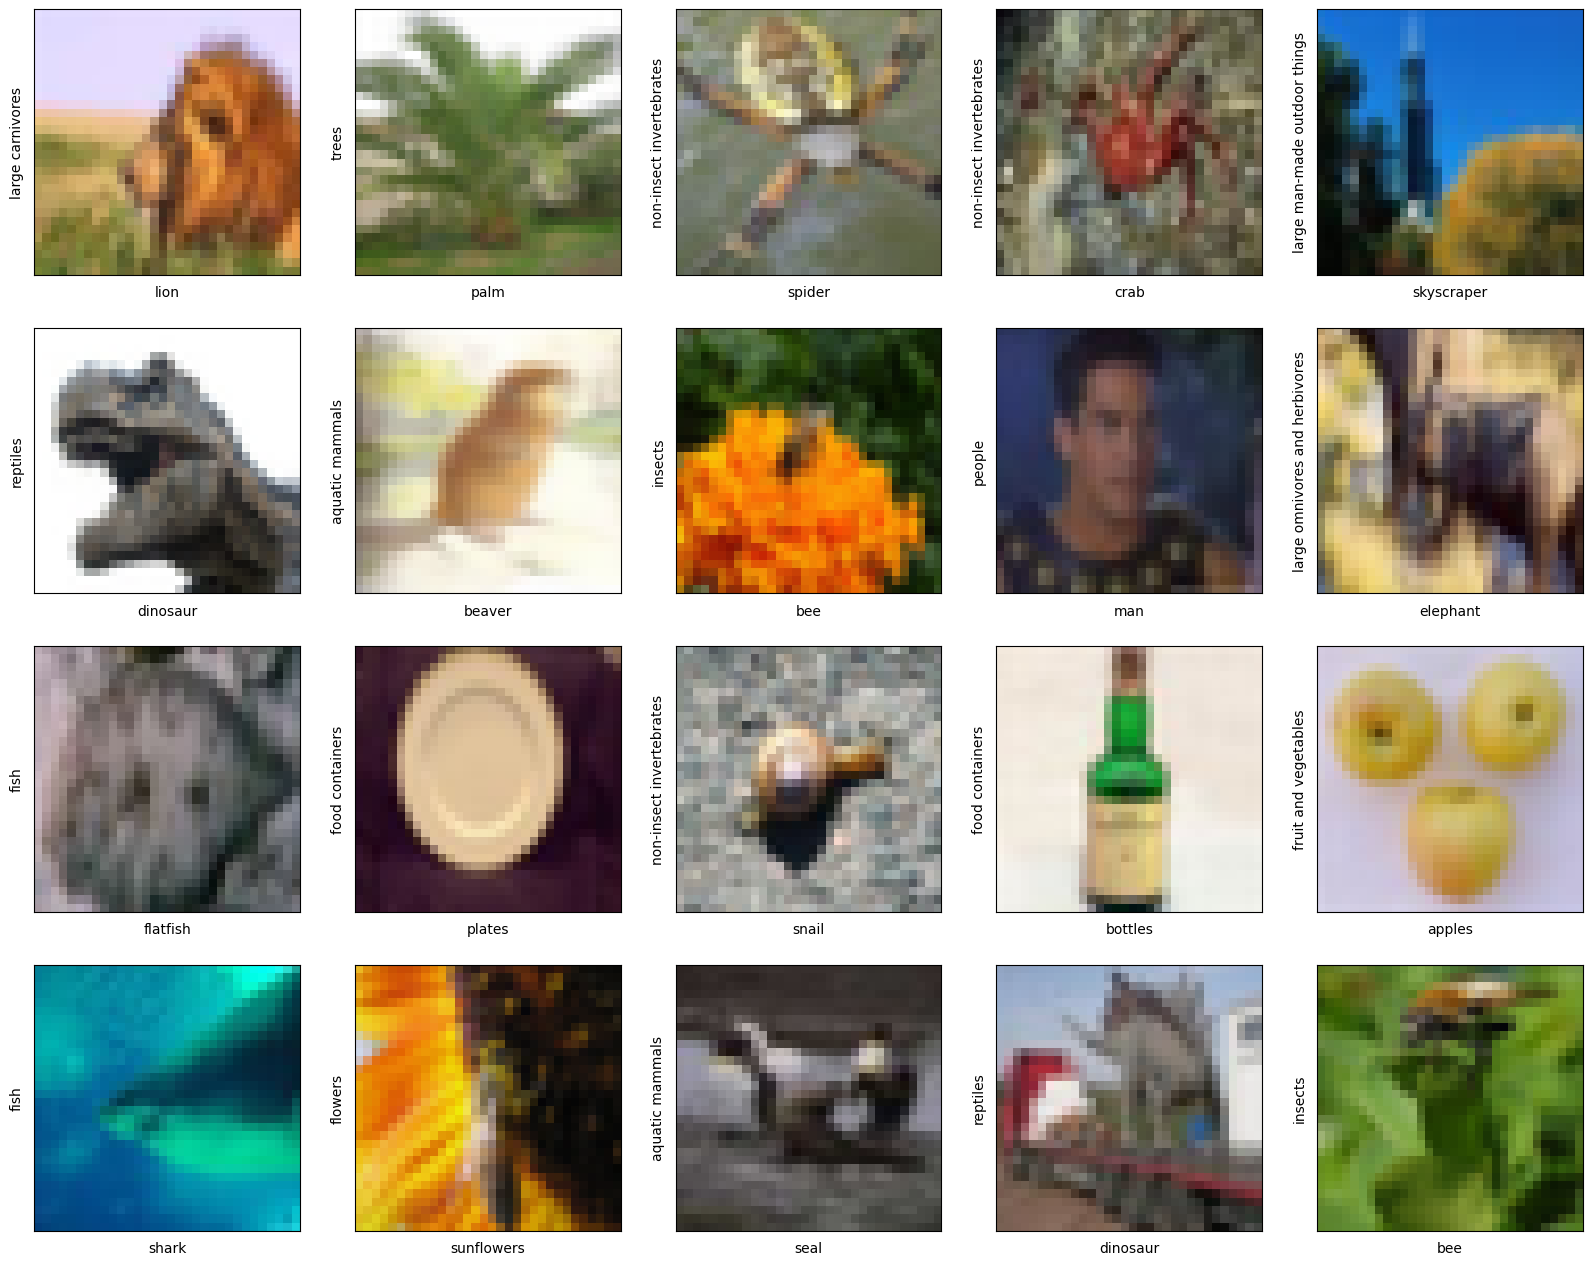

In [4]:
plt.figure(figsize=(20,20))

for i in range(0,20):
    x = random.randint(0, 49999)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trn[x])
    plt.xlabel(txtlb_fine[trnlb_fine[x]])
    plt.ylabel(txtlb_coarse[trnlb_coarse[x]])

plt.show()

## Data Generation

Lets print off a random image from the training set (again with the labels for fun)

(32, 32, 3)


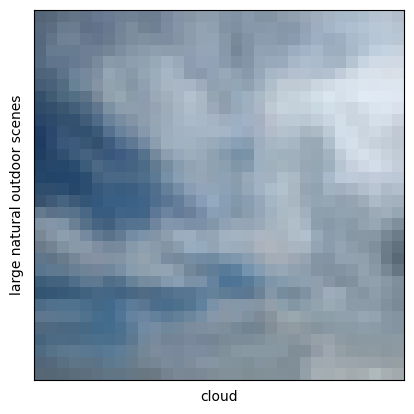

In [5]:
x = random.randint(0, 49999)
image = trn[x]
print(image.shape)
plt.xlabel(txtlb_fine[trnlb_fine[x]])
plt.ylabel(txtlb_coarse[trnlb_coarse[x]])
plt.xticks([])
plt.yticks([])
plt.imshow(image)

Here we can define what kind of manipulation we want to apply to the image for data generation. 
The augmentation is as follows in order
-Random shift along the y axis
-Random shift along the x axis
-Random rotation up to 20 degrees
-Random horizontal flip
-Random vertical flip
-Random shear
-Random ammount of zoom

In [6]:
datagen = ImageDataGenerator(
  width_shift_range=0.2, # shift along the x axis
  height_shift_range=0.2, # shift along the y axis
  rotation_range=20,
  horizontal_flip=True,
  vertical_flip = True,
  shear_range=0.25,
  zoom_range=0.25,
)

Lets take a look at some images that have been augmented to see what they look like after going through our datagen.
As we can see the images look mostly the same but just slightly adjusted. This is enough to prevent overfitting.

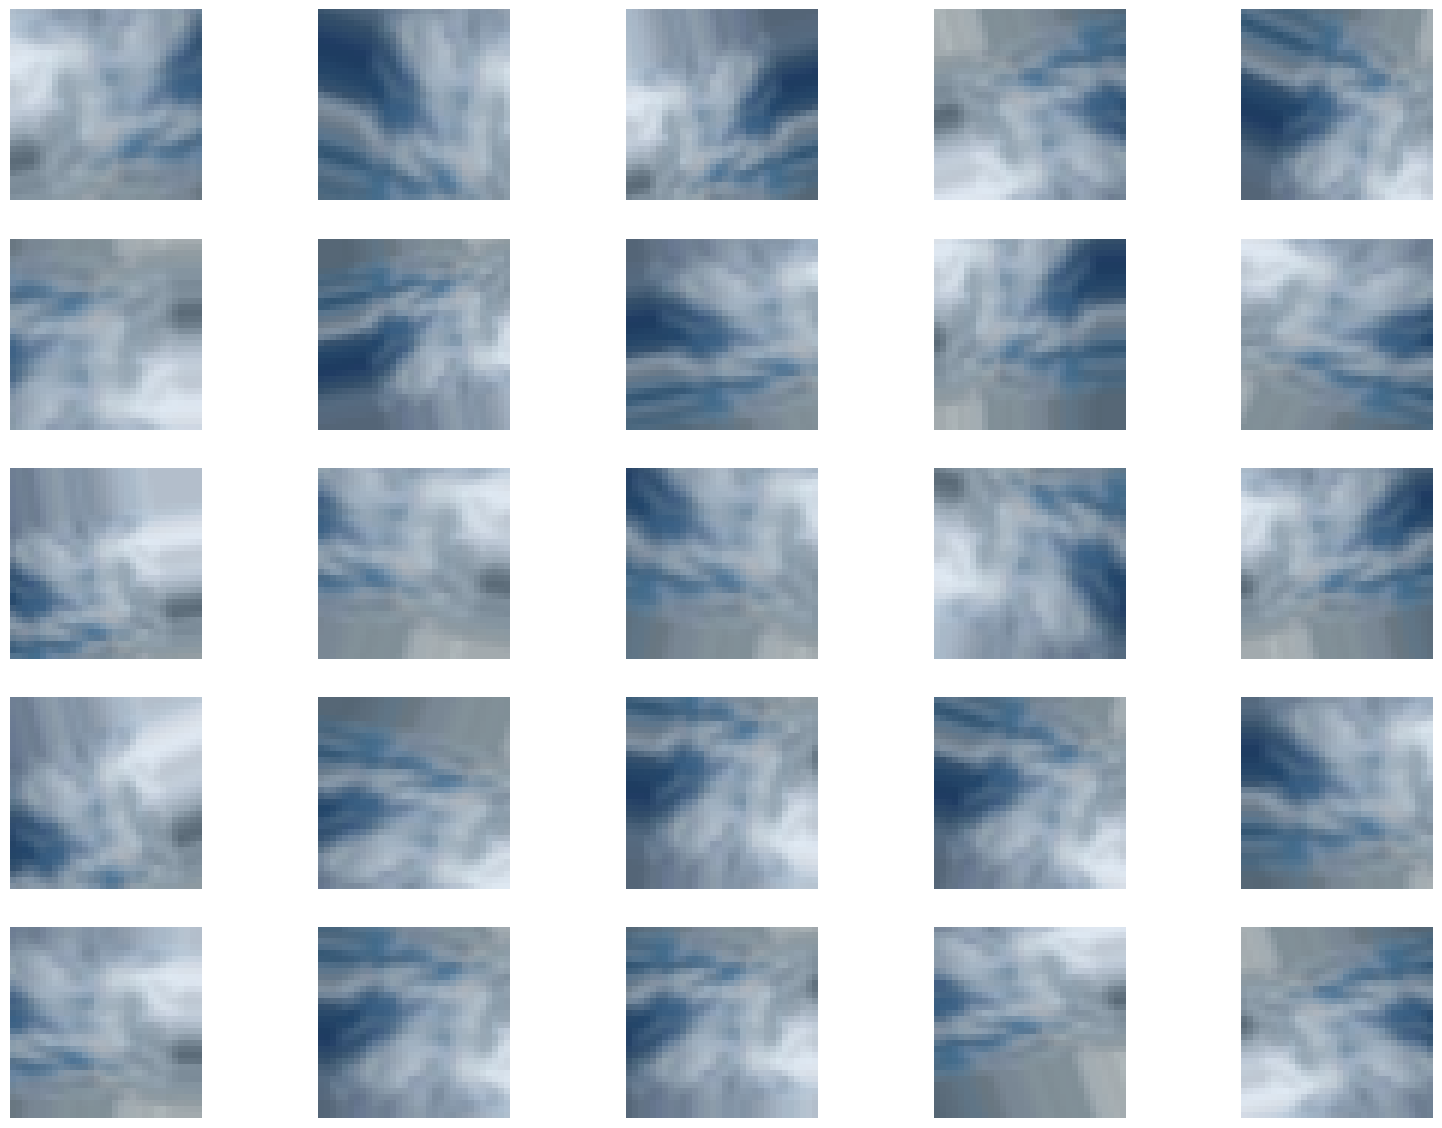

In [7]:
x = np.expand_dims(image, 0)
y = np.asarray(['any-label'])

figure = plt.figure()
i = 0
for x_batch, y_batch in datagen.flow(x, y):
  a = figure.add_subplot(5, 5, i + 1)
  plt.imshow(np.squeeze(x_batch))
  a.axis('off')
  if i == 24: break
  i += 1
figure.set_size_inches(np.array(figure.get_size_inches()) * 3)
plt.show()

Visualising the dataset after image augmentation. Here we can only print one of the labels as the datagen method only accepts one set of labels. But we can see that the images look the same with a bit more variation.

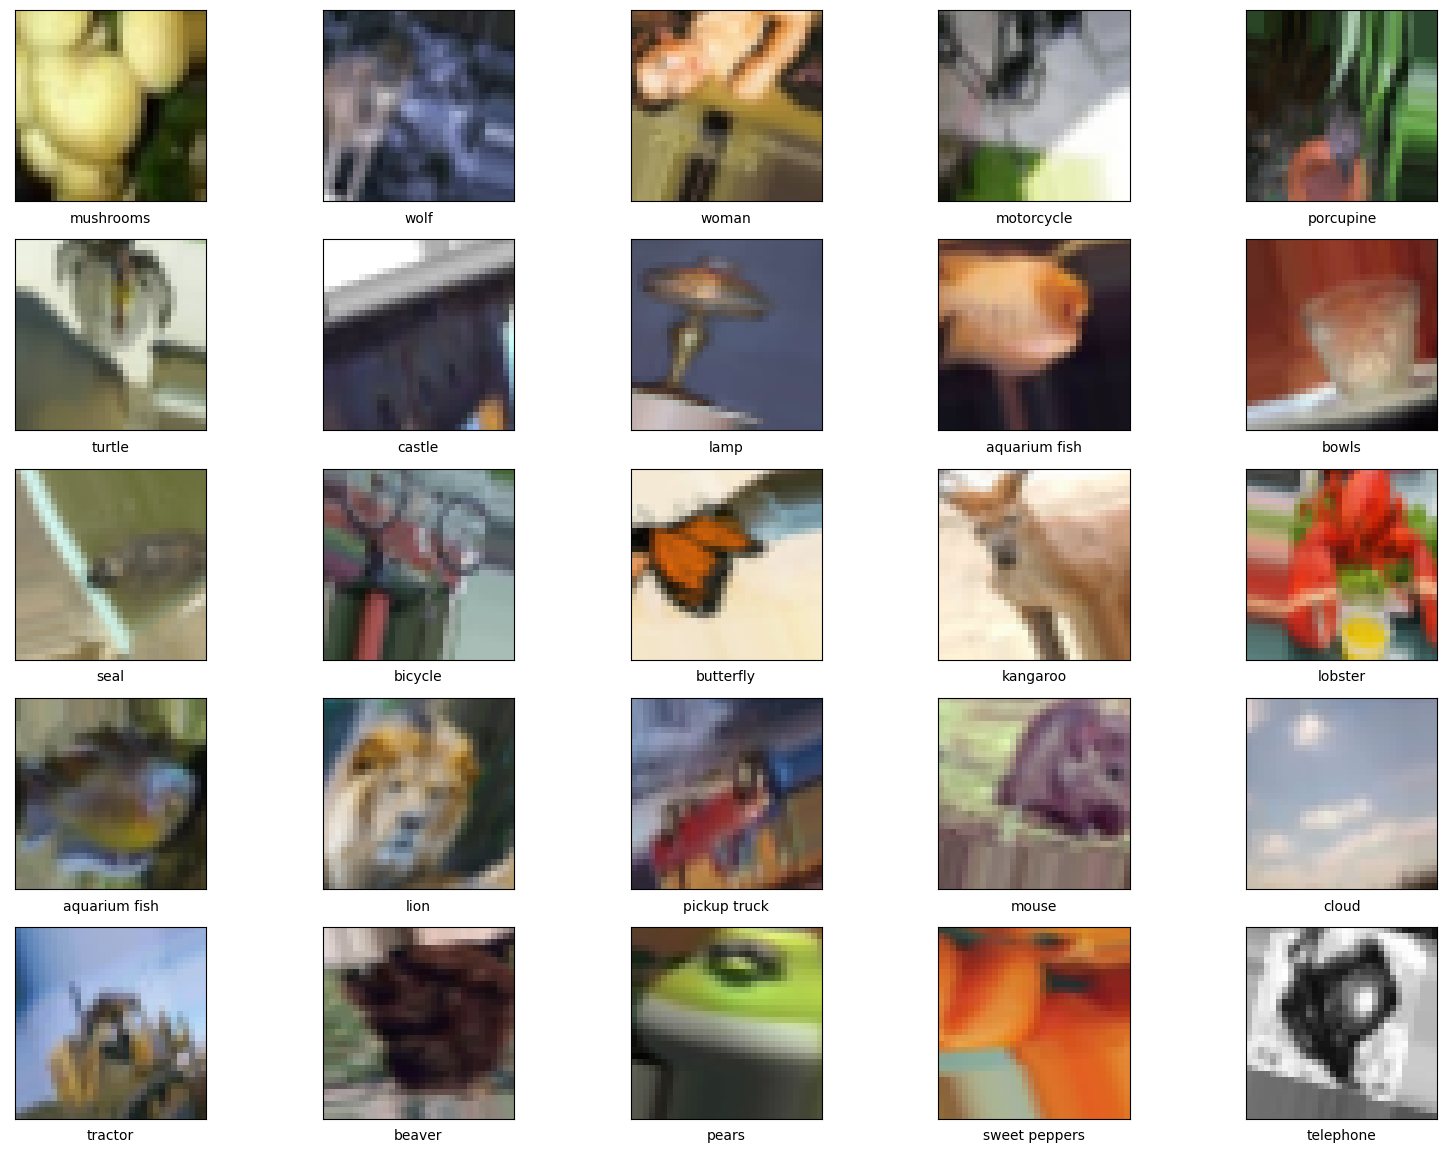

In [8]:
figure = plt.figure()
i = 0
for x_batch, y_batch in datagen.flow(trn, trnlb_fine):
    a = figure.add_subplot(5, 5, i + 1)
    plt.imshow(np.squeeze(x_batch[0]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(txtlb_fine[y_batch[0]])
    if i == 24: break
    i += 1
figure.set_size_inches(np.array(figure.get_size_inches()) * 3)
plt.show()

We need to make our data catagorical for the CNN. Currently our labels are in the form x,1 when we need them to reflect the number of catagories. e.g given labels of the form (0,1,2) instead of them being represented as the number they will be represented like this (1,0,0) for a label 0

In [9]:
trnlb_coarse = to_categorical(trnlb_coarse)
tstlb_coarse = to_categorical(tstlb_coarse)

trnlb_fine = to_categorical(trnlb_fine)
tst_fine = to_categorical(tstlb_fine)

As we can see this turns our lables into the correct shapes so they can represent the number of catagories properly.

In [10]:
print(trn.shape, trnlb_coarse.shape, tst.shape, tstlb_coarse.shape)

(50000, 32, 32, 3) (50000, 20) (10000, 32, 32, 3) (10000, 20)


# Fine labels Model

Defining our CNN model. Testing models before datagen this architecture gave me the best results (arround 30% over 100 epochs) We have 11 hidden layers in this model starting from the input layer I will describe each layer.
HL = Hidden Layer

Input - 128 3 by 3 filters with the relu activation function taking in the shape (32,32,3)

HL1 - 128 3 by 3 filters with the relu activation

HL2 - Batch Normalization to help with overfitting

HL3 - 2 by 2 maxpooling layer with a 1 by 1 stride length and padding of 2

HL4 - Dropout layer of 20% (to help with overfitting)

HL5 - 256 3 by 3 filters with the relu activation

HL6 - 256 3 by 3 filters with the relu activation

HL7 - 2 by 2 maxpooling layer with a 1 by 1 stride length and padding of 2

HL8 - Dropout layer of 40% (to help with overfitting)

HL9 - Flatten layer so we can map our data to the output shape

HL10 - Dense layer of 512 neurons using the relu activation so we can extract the features from our flattened data

HL11 - One last dropout layer of 50% to again help with overfitting

Output - A dense layer with 100 neurons(here its just set to the size of unique values in the training labels) using the softmax activation function

This is quite a large model and has over 135,000,000 trainable parameters

In [12]:
model_fine = models.Sequential()
model_fine.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_fine.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_fine.add(layers.BatchNormalization())
model_fine.add(layers.MaxPooling2D((2, 2), strides=(1,1), padding = 'same'))
model_fine.add(Dropout(0.2))
model_fine.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_fine.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_fine.add(layers.MaxPooling2D((2, 2), strides=(1,1), padding = 'same'))
model_fine.add(Dropout(0.4))
model_fine.add(layers.Flatten())
model_fine.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model_fine.add(Dropout(0.5))
model_fine.add(layers.Dense(fine, activation='softmax'))
model_fine.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       2

Next we split our training data into training and validataion so we only apply data augmentation to the training set

In [13]:
x_train, x_val, y_train, y_val = train_test_split(trn, trnlb_fine, test_size = 0.2)

Data generation in batches of 32. It is important to set the step size here otherwise we will run out of data to train the model with.

In [14]:
data_gen = datagen.flow(x_train, y_train, batch_size = 32)
steps = x_train.shape[0] // 32

Defining our model and optimiser with chosen learning rates and momentum.

In [15]:
opt = SGD(lr=0.001, momentum=0.9)
model_fine.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Now we train our model with the generated images for 100 epochs and providng steps. We now have to manually set the validation data as it is of a different form from our testing data.

In [16]:
history = model_fine.fit(
    data_gen, epochs=100,
    steps_per_epoch=steps,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/100
1250/1250 [==============================] - 78s 43ms/step - loss: 4.4048 - accuracy: 0.0391 - val_loss: 4.1688 - val_accuracy: 0.0770
Epoch 2/100
1250/1250 [==============================] - 53s 42ms/step - loss: 4.1152 - accuracy: 0.0759 - val_loss: 3.8480 - val_accuracy: 0.1271
Epoch 3/100
1250/1250 [==============================] - 54s 43ms/step - loss: 3.9216 - accuracy: 0.1040 - val_loss: 3.6015 - val_accuracy: 0.1621
Epoch 4/100
1250/1250 [==============================] - 54s 43ms/step - loss: 3.7766 - accuracy: 0.1224 - val_loss: 3.4868 - val_accuracy: 0.1727
Epoch 5/100
1250/1250 [==============================] - 54s 43ms/step - loss: 3.6474 - accuracy: 0.1421 - val_loss: 3.4142 - val_accuracy: 0.1836
Epoch 6/100
1250/1250 [==============================] - 54s 44ms/step - loss: 3.5408 - accuracy: 0.1591 - val_loss: 3.2369 - val_accuracy: 0.2212
Epoch 7/100
1250/1250 [==============================] - 54s 43ms/step - loss: 3.4497 - accuracy: 0.1784 - val_loss: 3

Plotting our training and validation loss and accuraccy we can see they are very close over all 100 epochs, this is a really good sign that our model is well trained and doesnt over or underfit. We can also see that the accuracy starts to flatten out. While the model could be trained for more epochs and would get more accurate the time it would take to improve the accuracy by a good ammount is too high to justify. We can also see the validation loss starts to diverge from the training loss, this means that past 100 epochs overfitting is likely to occur.

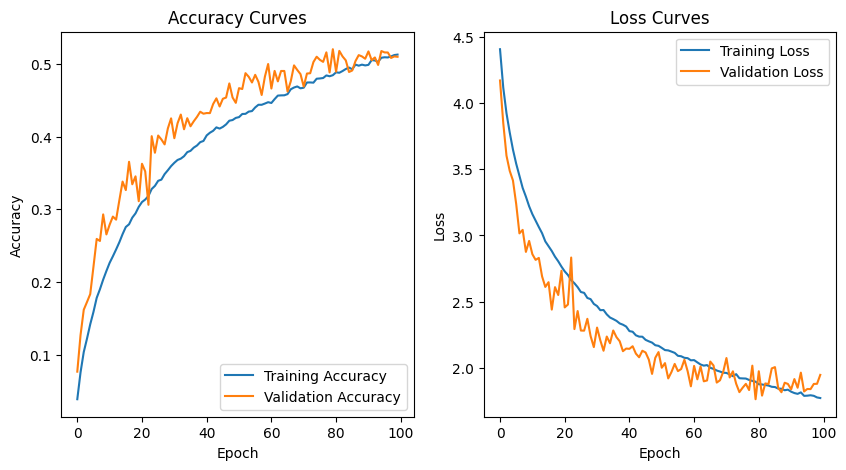

In [17]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

## Results of fine model

The trined model gets an accuracy of 51% on the test data which is very good considering the low resolution images and quantity of data.

In [18]:
results = model_fine.evaluate(tst, tst_fine)

print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

313/313 [==============================] - 3s 10ms/step - loss: 1.9399 - accuracy: 0.5186
Test set loss: 1.94, test set accuracy: 51.86%


# Coarse Model

The model for the coarse labels is the same but the output layer only has 20 neurons (set to the size of the length of unique values in the training labels)

In [6]:
model_coarse = models.Sequential()
model_coarse.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model_coarse.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_coarse.add(layers.BatchNormalization())
model_coarse.add(layers.MaxPooling2D((2, 2), strides=(1,1), padding = 'same'))
model_coarse.add(Dropout(0.2))
model_coarse.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_coarse.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model_coarse.add(layers.MaxPooling2D((2, 2), strides=(1,1), padding = 'same'))
model_coarse.add(Dropout(0.4))
model_coarse.add(layers.Flatten())
model_coarse.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model_coarse.add(Dropout(0.5))
model_coarse.add(layers.Dense(coarse, activation='softmax'))
model_coarse.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 256)      

Again splitting the data for validataion

In [21]:
x_train, x_val, y_train, y_val = train_test_split(trn, trnlb_coarse, test_size = 0.2)

Data generation

In [22]:
data_gen = datagen.flow(x_train, y_train, batch_size = 32)
steps = x_train.shape[0] // 32

Compiling the model with the same params

In [23]:
model_coarse.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Again fitting the model for 100 epochs and using the validation data.

In [24]:
history_coarse = model_coarse.fit(
    data_gen, epochs=100,
    steps_per_epoch=steps,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/100
1250/1250 [==============================] - 54s 43ms/step - loss: 2.6759 - accuracy: 0.1801 - val_loss: 2.4951 - val_accuracy: 0.2463
Epoch 2/100
1250/1250 [==============================] - 53s 43ms/step - loss: 2.4676 - accuracy: 0.2419 - val_loss: 2.2272 - val_accuracy: 0.3220
Epoch 3/100
1250/1250 [==============================] - 53s 43ms/step - loss: 2.3648 - accuracy: 0.2718 - val_loss: 2.1563 - val_accuracy: 0.3343
Epoch 4/100
1250/1250 [==============================] - 54s 43ms/step - loss: 2.2869 - accuracy: 0.2925 - val_loss: 2.2091 - val_accuracy: 0.3132
Epoch 5/100
1250/1250 [==============================] - 54s 43ms/step - loss: 2.2265 - accuracy: 0.3125 - val_loss: 2.1251 - val_accuracy: 0.3376
Epoch 6/100
1250/1250 [==============================] - 53s 43ms/step - loss: 2.1745 - accuracy: 0.3277 - val_loss: 1.9904 - val_accuracy: 0.3779
Epoch 7/100
1250/1250 [==============================] - 53s 43ms/step - loss: 2.1246 - accuracy: 0.3419 - val_loss: 1

From our training graphs we can see the data is fitted really well again. Once again its flattening out but could be more accurate with more epochs.

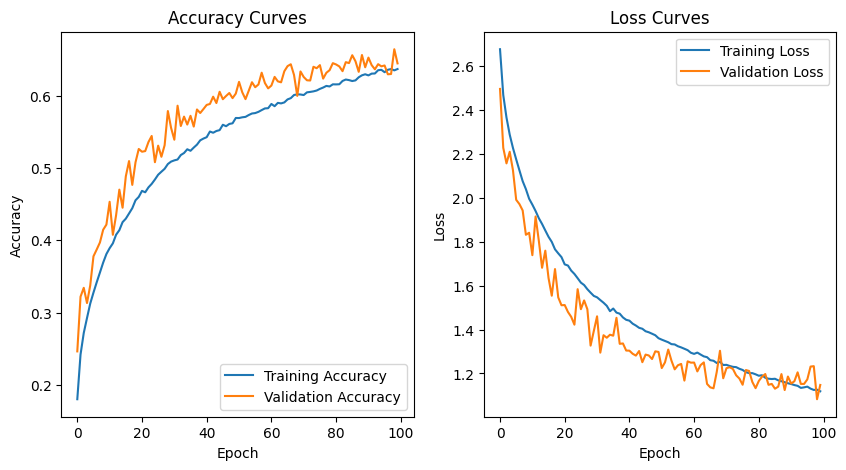

In [25]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history_coarse.history['accuracy'])
plt.plot(history_coarse.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history_coarse.history['loss'])
plt.plot(history_coarse.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

## Coarse model results

The coarse model gets an accuracy of 64% which is very good for the dataset and ammount of data

In [26]:
results = model_coarse.evaluate(tst, tstlb_coarse)

print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

313/313 [==============================] - 3s 10ms/step - loss: 1.1417 - accuracy: 0.6449
Test set loss: 1.14, test set accuracy: 64.49%


Saving the models weights so that I don't have to train it every time

In [27]:
model_fine.save('Models/Fine Model/fine_model.h5')
model_coarse.save('Models/Coarse Model/coarse_model.h5')

# Evaluating our models

First we need to predict labels for the test set using our model, lets start with fine labels

In [28]:
pred_fine = model_fine.predict(tst)

313/313 [==============================] - 3s 8ms/step


We need to change the labels back to numerical data from the catagorical data we made earlier so they can be compared easier.

In [29]:
predlb_fine = tf.argmax(pred_fine,1)
truelb_fine = tf.argmax(tst_fine,1)

Generating a confusion matrix

In [30]:
conf_matrix_fine = tf.math.confusion_matrix(truelb_fine, predlb_fine, fine)

When visulising the confusion matrix it is a bit difficult to read for the fine labels as there is so many catagories. But we can see that in general the model is pretty good. The lighter the square the more matching data between the predicted labels and the true labels. Looking at the top left we can see a good example where the model confuses bears and beavers quite a lot.

In [98]:
df = pd.DataFrame(conf_matrix_fine, columns = txtlb_fine)
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(100, 100)) 
sns.heatmap(df_corr, square=True, vmax=1, vmin=-1, center=0)

<AxesSubplot: >

Predicting coarse labels

In [33]:
pred_coarse = model_coarse.predict(tst)

313/313 [==============================] - 3s 8ms/step


again turning the labels into numerical data

In [34]:
predlb_coarse = tf.argmax(pred_coarse,1)
truelb_coarse = tf.argmax(tstlb_coarse,1)

Generating a confusion matrix for the coarse labels

In [36]:
conf_matrix_coarse = tf.math.confusion_matrix(truelb_coarse, predlb_coarse, coarse)

Looking at this confusion matrix we can read it a lot easier. Some standout misclassifications are the two vehical catagories which is understandable. Another is food containers and household electrical devices, this makes sense as they are similar shapes in similar background environments.

<AxesSubplot: >

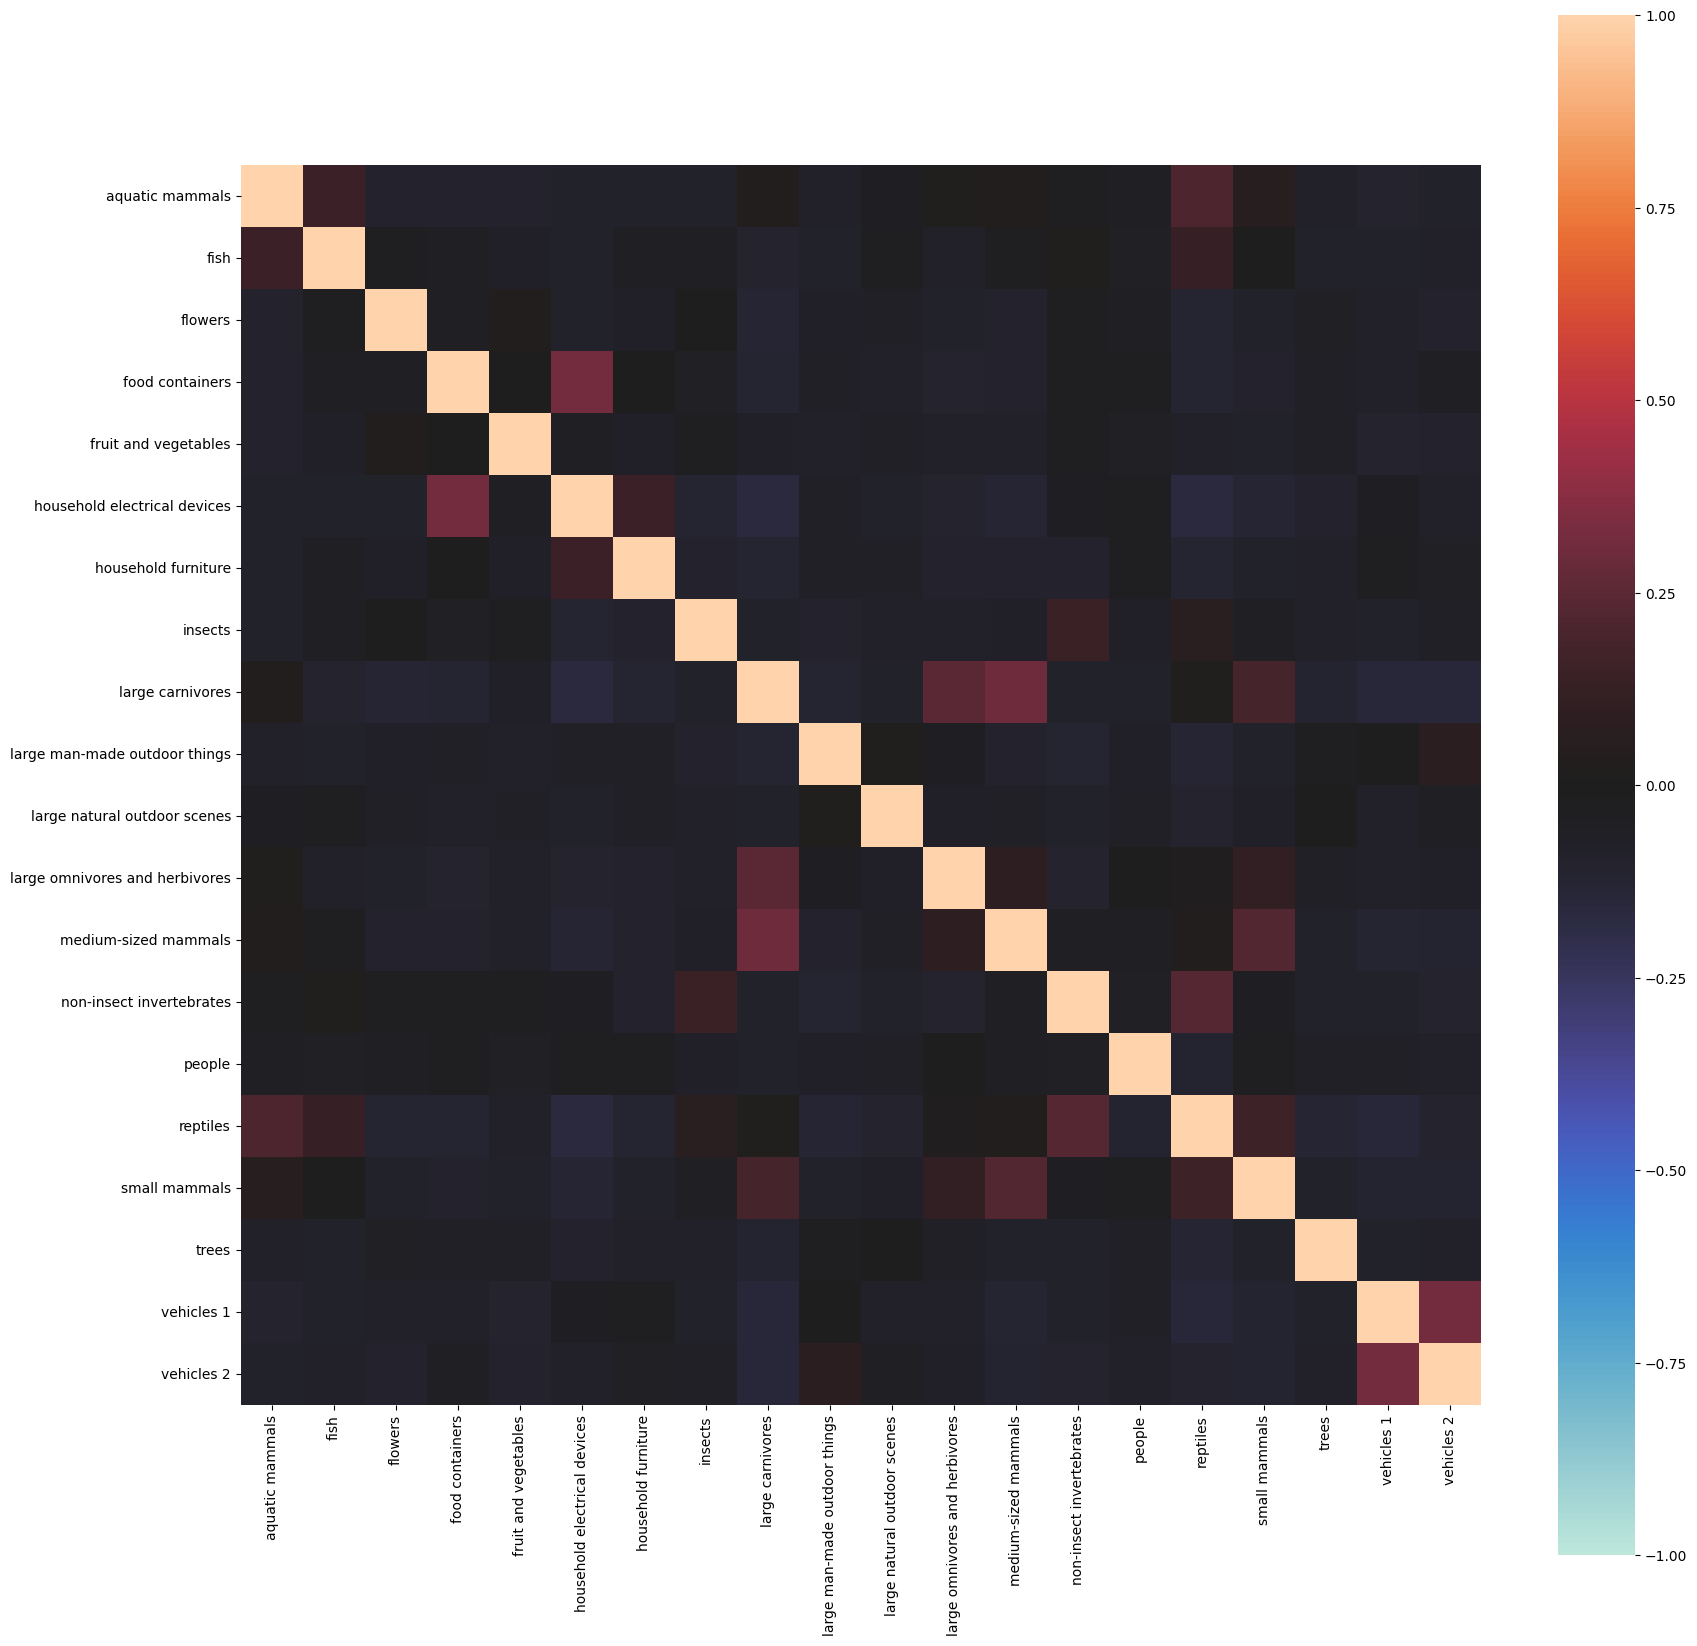

In [55]:
df = pd.DataFrame(conf_matrix_coarse, columns = txtlb_coarse)
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(df_corr, square=True, vmax=1, vmin=-1, center=0)

Just for fun lets look at a spesific example of missclassification. Here I am just getting the first misclassified image in the list. On the y axis we can see our models guess. On the x axis we can see the true catagory. I think the background of the image is the main cause of missclassifciation in this case. This could mean that the model is putting too much emphasis on the colours in the image. This can be solved by making the image greyscale or adding more detail to our model.

(32, 32, 3)


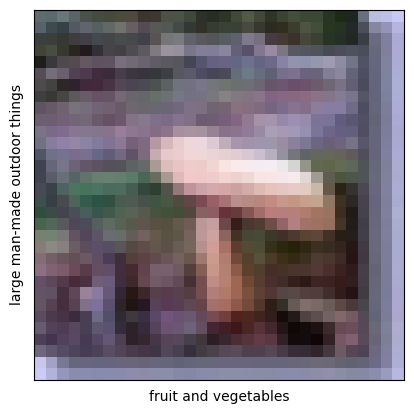

In [82]:
n = 0
flag = True
while flag == True:
    for images in tst:
        if predlb_coarse[n] == truelb_coarse[n]:
            n += 1
        else:
            flag = False
miss_img_coarse = tst[n]
print(miss_img_coarse.shape)
plt.xlabel(np.array(txtlb_coarse)[truelb_coarse[n]])
plt.ylabel(np.array(txtlb_coarse)[predlb_coarse[n]])
plt.xticks([])
plt.yticks([])
plt.imshow(miss_img_coarse)

We can also visualise all of the guesses our model has made. We can see that it was quite far off of getting it correct.

<AxesSubplot: xlabel='Catagories'>

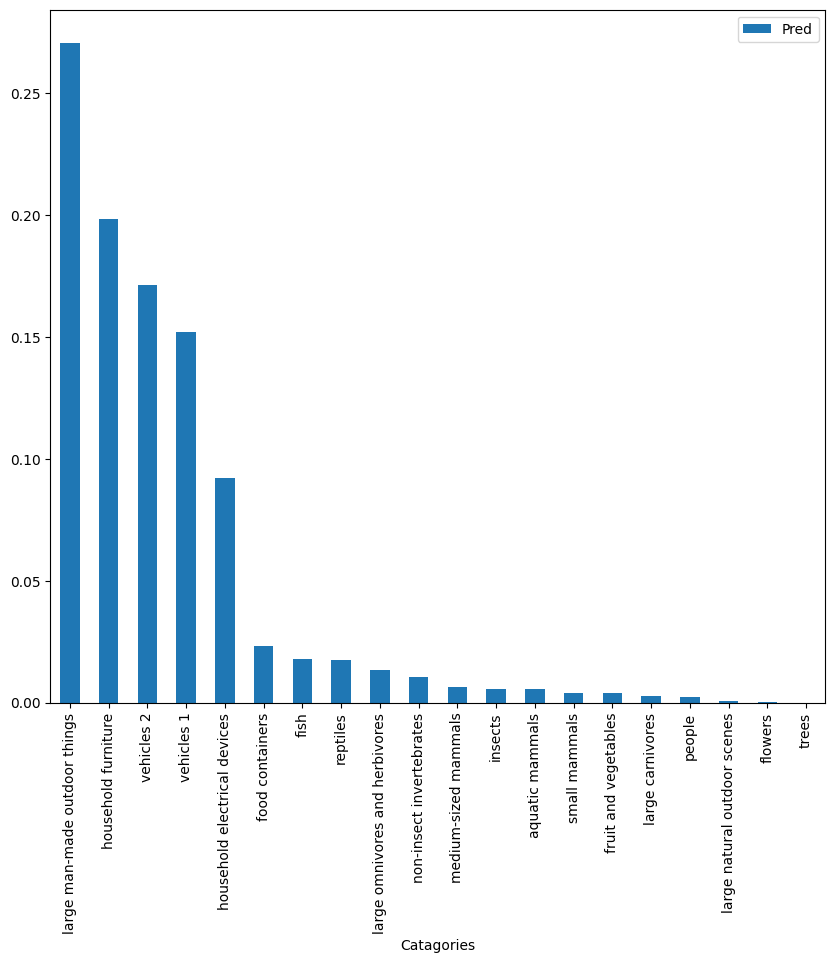

In [87]:
data = {"Catagories":txtlb_coarse,

        "Pred":pred_coarse[n]
        }

dataFrame = pd.DataFrame(data=data)
dataFrame.sort_values(by=['Pred'], inplace=True, ascending=False)
dataFrame.plot(x="Catagories", y="Pred", kind="bar", figsize=(10, 9))

Lets do the same with the fine labels. Here we can see the model thinks this is a picture of a beaver when it should be a seal. This makes sense as again the background colours are also quite similar and the colour of the seal is similar to that of a beaver. The same solutions might work (making the image greyscale or adding more complexity to our model.)

(32, 32, 3)


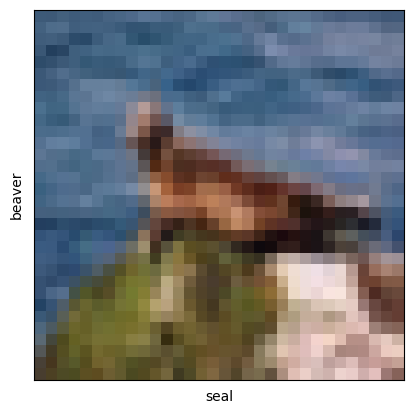

In [93]:
n = 0
flag = True
while flag == True:
    for images in tst:
        if predlb_fine[n] == truelb_fine[n]:
            n += 1
        else:
            flag = False
miss_img_fine = tst[n]
print(miss_img_fine.shape)
plt.xlabel(np.array(txtlb_fine)[truelb_fine[n]])
plt.ylabel(np.array(txtlb_fine)[predlb_fine[n]])
plt.xticks([])
plt.yticks([])
plt.imshow(miss_img_fine)

Since there is 100 catagories for the fine labels I have only plotted the models top 5 guesses and we can see that the seal catagory is in the top 5 which is good. However, it still has quite a low probability

<AxesSubplot: xlabel='Catagories'>

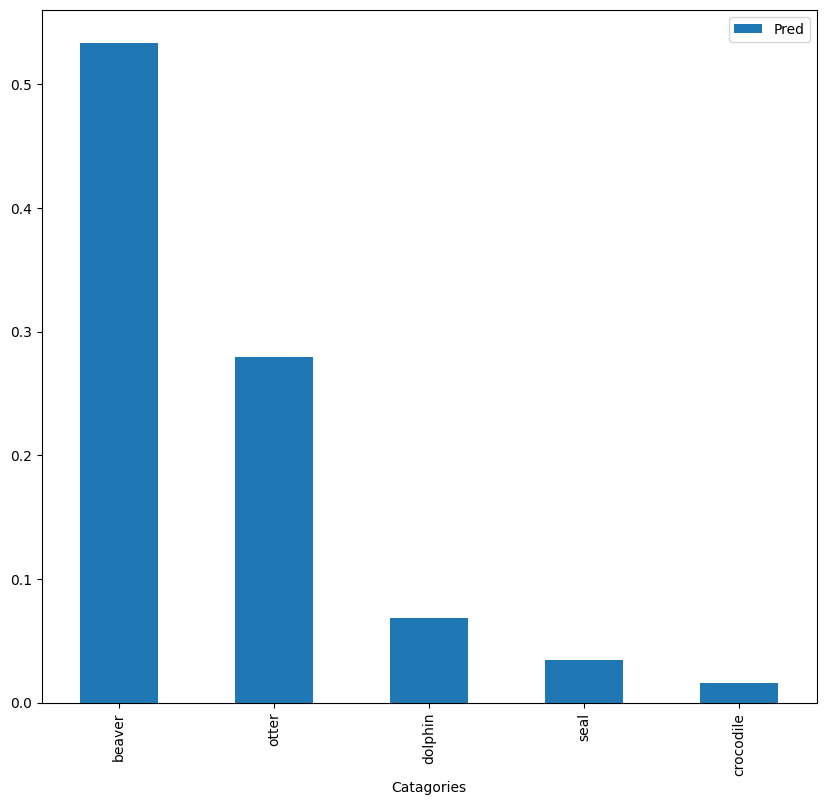

In [94]:
data = {"Catagories":txtlb_fine,
        "Pred":pred_fine[n]
        }

dataFrame = pd.DataFrame(data=data)
top_five = dataFrame.sort_values(by='Pred', ascending=False).head()
top_five.plot(x="Catagories", y="Pred", kind="bar", figsize=(10, 9))